# 1st Checkpoint

## Ипморт

In [1]:
!pip install shap

In [2]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=118d0fea3d354e00a62aab33c12248eb9cfa2fec23e701b543c13414375844b2
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.9 MB/s eta 0:00:00


In [4]:
import kagglehub

path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'formula-1-world-championship-1950-2020' dataset.
Path to dataset files: /kaggle/input/formula-1-world-championship-1950-2020


In [61]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
import shap

os.listdir(path)

['races.csv',
 'constructor_results.csv',
 'drivers.csv',
 'constructors.csv',
 'lap_times.csv',
 'status.csv',
 'driver_standings.csv',
 'seasons.csv',
 'pit_stops.csv',
 'sprint_results.csv',
 'constructor_standings.csv',
 'results.csv',
 'circuits.csv',
 'qualifying.csv']

In [6]:
#constructors          = pd.read_csv(os.path.join(path, "constructors.csv"))
qualifying            = pd.read_csv(os.path.join(path, "qualifying.csv")) # position по raceId и driverId
results               = pd.read_csv(os.path.join(path, "results.csv"))
races                 = pd.read_csv(os.path.join(path, "races.csv"))
driver_standings      = pd.read_csv(os.path.join(path, "driver_standings.csv"))
#sprint_results        = pd.read_csv(os.path.join(path, "sprint_results.csv"))
#status                = pd.read_csv(os.path.join(path, "status.csv"))
#pit_stops             = pd.read_csv(os.path.join(path, "pit_stops.csv"))
lap_times             = pd.read_csv(os.path.join(path, "lap_times.csv"))
drivers               = pd.read_csv(os.path.join(path, "drivers.csv"))
circuits              = pd.read_csv(os.path.join(path, "circuits.csv")) #брать location по circuitId
#seasons               = pd.read_csv(os.path.join(path, "seasons.csv"))
#constructor_results   = pd.read_csv(os.path.join(path, "constructor_results.csv"))
#constructor_standings = pd.read_csv(os.path.join(path, "constructor_standings.csv"))

## EDA

У нас есть 14 датасетов, содержащие разную информацию о гонках forlmula 1. Мы для обучения будем использовать информацию из 3-х датасетов:
1. races
2. results
3. lap_times
4. circuits

### qualifying


Датасет содержит следующую информацию:

1. **qualifyId**

Уникальный ID записи квалификации. Используется как первичный ключ.

2. **raceId**

Идентификатор гонки, в которой проходила квалификация. Можно связать с датасетом races для получения информации о Гран-при.

3. **driverId**

ID пилота, участвовавшего в квалификации.

4. **constructorId**

ID конструкторской команды, за которую выступал пилот.

5. **number**

Номер гонщика на болиде в этой гонке/сезоне

6. **position**

Итоговая позиция в квалификации (1 = поул-позиция).
Если пилот не поучаствовал или был дисквалифицирован, может быть пустым.

7. **q1**

Лучшая попытка пилота в первой стадии квалификации.
Формат: ММ:СС.sss
Например: 1:26.572
Может быть \N, если пилот не участвовал в Q1 или данные отсутствуют.

8. **q2**

Время пилота во второй стадии квалификации.
Имеет значение только для тех, кто прошёл в Q2.
Если пилот выбыл после Q1, то \N.

9. **q3**

Время пилота в финальной стадии.
Значение есть только у топ-10.
У остальных - \N.

---

Из этого датасета мы будем брать **position** по **raceId** и **driverId**, чтобы знать на каком месте финишировал тот или иной гонщик в конкретной гонке.

In [ ]:
qualifying.head(10)

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
5,6,18,15,7,11,6,1:26.427,1:26.101,1:28.527
6,7,18,3,3,7,7,1:26.295,1:26.059,1:28.687
7,8,18,14,9,9,8,1:26.381,1:26.063,1:29.041
8,9,18,10,7,12,9,1:26.919,1:26.164,1:29.593
9,10,18,20,5,15,10,1:26.702,1:25.842,\N


In [ ]:
qualifying.dtypes

,0
qualifyId,int64
raceId,int64
driverId,int64
constructorId,int64
number,int64
position,int64
q1,object
q2,object
q3,object


### results


Датасет содержит следующую информацию:

1. **resultId**

Уникальный ID результата.

2. **raceId**

Идентификатор гонки (Гран-при).

3. **driverId**

Идентификатор пилота.

4. **constructorId**

Идентификатор команды.

5. **number**

Стартовый номер болида

6. **grid**

Из какой позиции пилот стартовал.
1 — поул-позиция.

*Значение не обязательно совпадает с результатами квалификации (штрафы, замены двигателя и т.п.).*

7. **position**

Финальная позиция пилота в гонке.
Может быть \N, если не финишировал.

8. **positionText**

Строковое обозначение позиции.

9. **positionOrder**

Числовой порядок финиша.

10. **points**

Количество очков, начисленных пилоту за гонку.

11. **laps**

Сколько кругов пилот проехал.

12. **time**

Либо общее время гонки (для победителя),
либо отставание от победителя (например +5.478),
либо \N, если пилот не финишировал.

13. **milliseconds**

Время гонки в миллисекундах.

14. **fastestLap**

Номер круга, на котором этот пилот проехал свой лучший круг.

15. **rank**

Позиция пилота по скорости лучшего круга в гонке.
1 = самый быстрый круг.

16. **fastestLapTime**

Время лучшего круга пилота.

17. **fastestLapSpeed**

Средняя скорость пилота на его быстрейшем круге (км/ч).

18. **statusId** - статус, в котором пилот завершил гонку. Расшифровка в датасете status, это нам не понадобится.

---
Из этого датасета мы будем брать **grid** по **raceId** и **driverId**, чтобы понимать с какой позиции стартовал пилот.

In [7]:
results.head(10)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1
5,6,18,6,3,8,13,6,6,6,3.0,57,\N,\N,50,14,1:29.639,212.974,11
6,7,18,7,5,14,17,7,7,7,2.0,55,\N,\N,54,8,1:29.534,213.224,5
7,8,18,8,6,1,15,8,8,8,1.0,53,\N,\N,20,4,1:27.903,217.180,5
8,9,18,9,2,4,2,\N,R,9,0.0,47,\N,\N,15,9,1:28.753,215.100,4
9,10,18,10,7,12,18,\N,R,10,0.0,43,\N,\N,23,13,1:29.558,213.166,3


In [8]:
results.dtypes

,0
resultId,int64
raceId,int64
driverId,int64
constructorId,int64
number,object
grid,int64
position,object
positionText,object
positionOrder,int64
points,float64


### races

Важный датасет. Содержит следующую информацию:

1. **raceId**
Уникальный ID гонки.

2. **year**

Год проведения гонки.

3. **round**

Порядковый номер этапа сезона.

4. **circuitId**

ID автодрома, на котором проводилась гонка.

5. **name**

Официальное название Гран-при.

6. **date**

Дата проведения гонки.

7. **time**

Время старта гонки.

8. **url**

Ссылка на страницу Википедии с подробностями о Гран-при.

9. **fp1_date**

Дата FP1.

10. **fp1_time**

Время FP1.

11. **fp2_date**

Дата FP2.

12. **fp2_time**

Время FP2.

13. **fp3_date**

Дата FP3.

14. **fp3_time**

Время FP3.

15. **quali_date**

Дата квалификации.

16. **quali_time**

Время старта квалификации.

17. **sprint_date**

Дата спринт-гонки.

18. **sprint_time**
Время начала спринта.

----
Из этого датасета мы берём **year**, **circuitId**, **date** по **raceId**, чтобы в итоговом датасете была информация про год гонки, локацию (по circuitId узнаем автодром и его локацию) и дату проведения. Дата и локация нужны для того, чтобы добавить в итоговый датасет ещё и погодные условия.

In [9]:
races.head(5)

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [10]:
races.dtypes

,0
raceId,int64
year,int64
round,int64
circuitId,int64
name,object
date,object
time,object
url,object
fp1_date,object
fp1_time,object


### lap_times

Тоже очень важный датасет, можно сказать основной. На его основе мы будем маркировать гонки, в которых появлялась safety car.

Датасет содержит следующую информацию:

1. **raceId**

ID гонки (Гран-при).

2. **driverId**

Идентификатор пилота.

3. **lap**

Номер круга.

4. **position**

Позиция пилота на трассе после завершения данного круга.

5. **time**

Время круга

6. **milliseconds**
То же самое время круга, но выраженное в миллисекундах.
---
Тут нам понадобятся все данные, кроме time(Вместо него будем работать с **milliseconds**).

In [11]:
lap_times.head(10)

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342
5,841,20,6,1,1:32.605,92605
6,841,20,7,1,1:32.502,92502
7,841,20,8,1,1:32.537,92537
8,841,20,9,1,1:33.240,93240
9,841,20,10,1,1:32.572,92572


In [12]:
lap_times.dtypes

,0
raceId,int64
driverId,int64
lap,int64
position,int64
time,object
milliseconds,int64


### circuits

Датасет содержит следующую информацию:

1. **circuitId**

Уникальный числовой идентификатор трассы.

2. **circuitRef**

Короткое имя трассы.

3. **name**

Полное официальное название трассы.

4. **location**

Город/населённый пункт, где расположен автодром.

5. **country**

Страна, где находится трасса.

6. **lat**

Географическая широта в градусах.

7. **lng**

Географическая долгота.

8. **alt**

Высота трассы над уровнем моря.

9. **url**

Ссылка на страницу Википедии с подробным описанием трассы.

---
Из датасеты мы будем брать **location** по **circuitId**.

In [13]:
circuits.head(10)

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park
5,6,monaco,Circuit de Monaco,Monte-Carlo,Monaco,43.73470,7.42056,7,http://en.wikipedia.org/wiki/Circuit_de_Monaco
6,7,villeneuve,Circuit Gilles Villeneuve,Montreal,Canada,45.50000,-73.52280,13,http://en.wikipedia.org/wiki/Circuit_Gilles_Vi...
7,8,magny_cours,Circuit de Nevers Magny-Cours,Magny Cours,France,46.86420,3.16361,228,http://en.wikipedia.org/wiki/Circuit_de_Nevers...
8,9,silverstone,Silverstone Circuit,Silverstone,UK,52.07860,-1.01694,153,http://en.wikipedia.org/wiki/Silverstone_Circuit
9,10,hockenheimring,Hockenheimring,Hockenheim,Germany,49.32780,8.56583,103,http://en.wikipedia.org/wiki/Hockenheimring


In [14]:
circuits.dtypes

,0
circuitId,int64
circuitRef,object
name,object
location,object
country,object
lat,float64
lng,float64
alt,int64
url,object


## Обработка lap_times

### Выбросы

В некоторых гонках есть аномальные высокие значения milliseconds. Например:

In [15]:
# Считаем среднее время круга по гонке и кругу.
lap_mean = (
    lap_times
        .groupby(["raceId", "lap"])["milliseconds"]
        .mean()
        .reset_index()
        .rename(columns={"milliseconds": "mean_lap_time"})
)

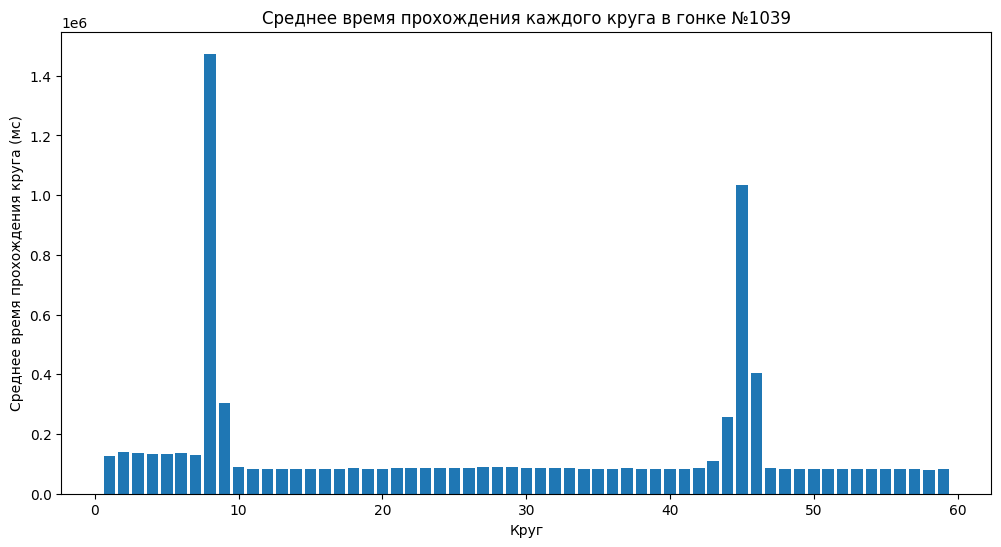

In [16]:
race_id = 1039

race_lap_mean = lap_mean[lap_mean["raceId"] == race_id]

plt.figure(figsize=(12, 6))
plt.bar(race_lap_mean["lap"], race_lap_mean["mean_lap_time"])

plt.xlabel("Круг")
plt.ylabel("Среднее время прохождения круга (мс)")
plt.title(f"Среднее время прохождения каждого круга в гонке №{race_id}")

plt.show()


Мы видим странные пики на 8 и 45 кругах, которые портят всё отображение графика, тк они аномально большие по сравнению с остальными кругами.

In [17]:
races[races['raceId'] == race_id]

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1026,1039,2020,9,76,Tuscan Grand Prix,2020-09-13,13:10:00,http://en.wikipedia.org/wiki/2020_Tuscan_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


Как видим, это Tuscan Grand Prix, который прошел 13 сентября 2020 года. Давайте посмотрим, что могло стать причиной таких выбросов.

https://www.youtube.com/watch?v=R-Yq1AlIwsc

Видим, что в самом начале 8-го круга произошло массовое столкновение боллидов. В связи с этим был поднят крассный флаг и гонка была остановлена. Значит мы выяснили откуда взялась первая аномалия - остановка гонки.

Смотрим дальше и видим, что на 44-м кругу Lance Stroll вылетает с трассы, в связи с чем уже во-второй раз поднимается красный флаг и гонка останавливается.

То есть, мы можем сделать вывод, что такие выбросы в гонках означают красный флаг. Наша задача - предсказать выезд safety car, тогда для корректной обработки данных мы предлагаем удалить такие аномалии.

In [18]:
# Создаём clean_race_stats
clean_race_stats = lap_times.merge(
    lap_mean,
    on=["raceId", "lap"],
    how="left"
)[["raceId", "driverId", "lap", "mean_lap_time"]]

def detect_outliers(group, threshold=70):
    med = group["mean_lap_time"].median()
    mad = np.median(np.abs(group["mean_lap_time"] - med))
    if mad == 0:
        return []
    outliers = group[
        np.abs(group["mean_lap_time"] - med) > threshold * mad
    ]["lap"].tolist()
    return [lap for lap in outliers if lap != 1]

In [19]:
# Находим круги, на которых гонку остановили
outlier_laps = (
    lap_mean.groupby("raceId")
            .apply(detect_outliers)
            .to_dict()
)

# расставляем флаги race_stop - круги, на которых показали красный флаг
clean_race_stats["race_stop"] = clean_race_stats.apply(
    lambda row: 1 if row["lap"] in outlier_laps.get(row["raceId"], []) else 0,
    axis=1
)

# зануляем выбросы, чтобы графики нормально отображались
clean_race_stats.loc[clean_race_stats["race_stop"] == 1, "mean_lap_time"] = 0


/tmp/ipython-input-2504852714.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(detect_outliers)


Результат:

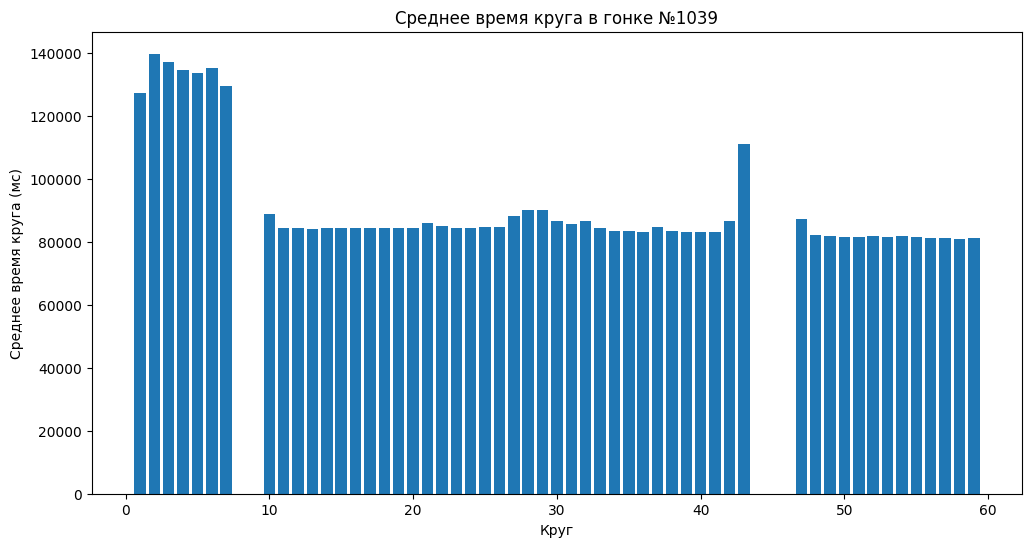

In [20]:
cur_race_stats = clean_race_stats[clean_race_stats['raceId'] == race_id]

plot_data = cur_race_stats.groupby('lap')['mean_lap_time'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(plot_data['lap'], plot_data['mean_lap_time'])

plt.xlabel("Круг")
plt.ylabel("Среднее время круга (мс)")
plt.title(f"Среднее время круга в гонке №{race_id}")

plt.show()

Мы удалили аномальные значения, теперь график отображается корректно.

### Разметка

Нас интересует флаг safety_car_race, который бы показавал выезжал ли хоть раз safety car на трассу.

Для этого предлагаем проанализировать среднее время прохождения круга. Если вдруг по ходу гонки мы видим круг, среднее время прохождения которого достаточно сильно отличается от времени прохождения остальных кругов, то мы делаем вывод, что на этом кругу на трассу выехал safety car.

Рассмотрим другой пример:

In [21]:
race_id = 1139

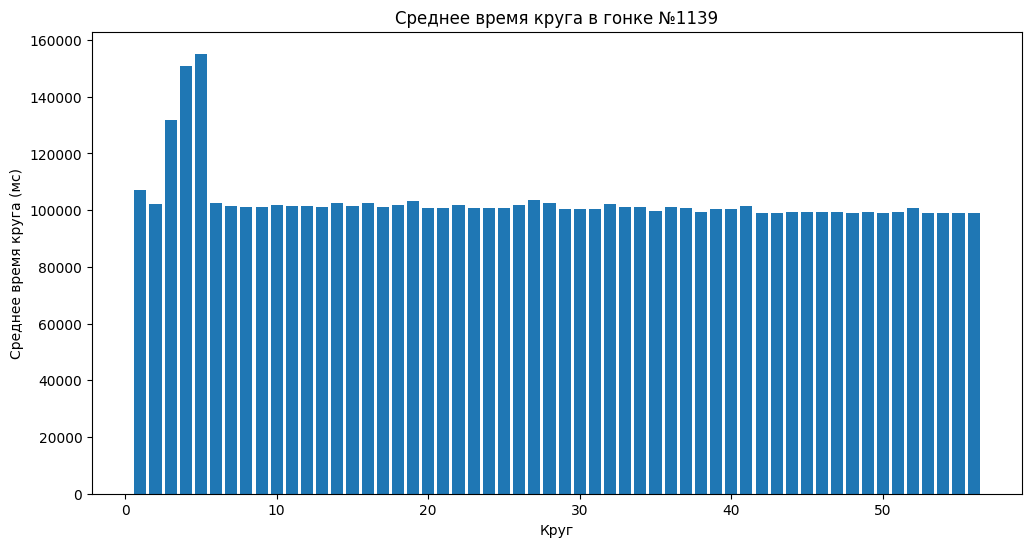

In [22]:
cur_race_stats = clean_race_stats[clean_race_stats['raceId'] == race_id]

plot_data = cur_race_stats.groupby('lap')['mean_lap_time'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(plot_data['lap'], plot_data['mean_lap_time'])

plt.xlabel("Круг")
plt.ylabel("Среднее время круга (мс)")
plt.title(f"Среднее время круга в гонке №{race_id}")

plt.show()

Видим, что на кругах 3-5 среднее время прохождения сильно(в 1.5 раза) отличается от остальных кругов.

In [23]:
races[races['raceId'] == race_id]

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
1119,1139,2024,19,69,United States Grand Prix,2024-10-20,19:00:00,https://en.wikipedia.org/wiki/2024_United_Stat...,2024-10-18,17:30:00,2024-10-18,21:30:00,\N,\N,2024-10-19,22:00:00,2024-10-19,18:00:00


Этот график показывает время прохождения кругов на United States Grand Prix 20 октября 2024 года. Посмотрим что там случилось.

https://www.formula1.com/en/video/highlights-2024-united-states-grand-prix.1813470035409054672?utm_source=google&utm_medium=organic&utm_campaign=google-onebox-highlights&utm_content=2024-united-states-race-highlights

Видим, что Lewis Hamilton вылетел с трассы и застрял в гравийной ловушке, из-за чего на 3-м кругу на трассу вывели safety car и убрали её только в конце 5-го круга.

Значит кажется, что наша гепотеза верна, и если по ходу гонки мы видим круг, среднее время прохождения которого достаточно сильно отличается от времени прохождения остальных кругов, то мы делаем вывод, что на этом кругу на трассу выехал safety car.

In [24]:
def detect_safety_car(group, threshold=10):
    med = group["mean_lap_time"].median()
    mad = np.median(np.abs(group["mean_lap_time"] - med))
    if mad == 0:
        return []
    sc_laps = group[np.abs(group["mean_lap_time"] - med) > threshold * mad]["lap"].tolist()
    return [lap for lap in sc_laps if lap != 1]


safety_car_laps = (lap_mean.groupby("raceId").apply(detect_safety_car).to_dict())


# Добавляем флаг safety_car в наш датасет
clean_race_stats["safety_car"] = clean_race_stats.apply(lambda row: 1 if row["lap"] in safety_car_laps.get(row["raceId"], []) else 0, axis=1)


# Добавляем флаг safety_car_race, который показывает была ли safety car в гонке вообще
race_has_sc = (clean_race_stats.groupby("raceId")["safety_car"].max().to_dict())
clean_race_stats["safety_car_race"] = clean_race_stats["raceId"].map(race_has_sc)

/tmp/ipython-input-3895735323.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  safety_car_laps = (lap_mean.groupby("raceId").apply(detect_safety_car).to_dict())


In [25]:
clean_race_stats[(clean_race_stats['raceId'] == race_id) & (clean_race_stats['safety_car'] == 1)]['lap'].unique()

array([3, 4, 5])

Видим, что мы верно разметили датасет. Теперь мы точно знаем на каких кругах safety car была на трассе.

### Добавляем информацию о погодных условиях

Теперь нам интересно, чтобы модель также смотрела на погоду,  и брала ее в расчет, добавим в датасет данные о погоды подтянутые через API

In [26]:
clean_race_stats = clean_race_stats.merge(
    races[['raceId', 'circuitId', 'date']],
    on='raceId',
    how='left')


clean_race_stats = clean_race_stats.merge(
    circuits[['circuitId', 'location']],
    on='circuitId',
    how='left')

In [27]:
clean_race_stats

,raceId,driverId,lap,mean_lap_time,race_stop,safety_car,safety_car_race,circuitId,date,location
0,841,20,1,112015.090909,0,0,1,1,2011-03-27,Melbourne
1,841,20,2,96863.363636,0,0,1,1,2011-03-27,Melbourne
2,841,20,3,95564.954545,0,0,1,1,2011-03-27,Melbourne
3,841,20,4,95148.636364,0,0,1,1,2011-03-27,Melbourne
4,841,20,5,95357.500000,0,0,1,1,2011-03-27,Melbourne
...,...,...,...,...,...,...,...,...,...,...
589076,1144,857,54,88958.000000,0,0,1,24,2024-12-08,Abu Dhabi
589077,1144,857,55,88921.588235,0,0,1,24,2024-12-08,Abu Dhabi
589078,1144,857,56,90226.625000,0,0,1,24,2024-12-08,Abu Dhabi
589079,1144,857,57,88701.187500,0,0,1,24,2024-12-08,Abu Dhabi


In [28]:
unique_races = clean_race_stats[['raceId', 'location', 'date', 'safety_car_race']].drop_duplicates()
unique_races = unique_races.reset_index(drop=True)

In [29]:
unique_races

,raceId,location,date,safety_car_race
0,841,Melbourne,2011-03-27,1
1,842,Kuala Lumpur,2011-04-10,0
2,843,Shanghai,2011-04-17,0
3,844,Istanbul,2011-05-08,0
4,845,Montmeló,2011-05-22,0
...,...,...,...,...
539,1140,Mexico City,2024-10-27,1
540,1141,São Paulo,2024-11-03,1
541,1142,Las Vegas,2024-11-23,0
542,1143,Al Daayen,2024-12-01,1


Мы подготовили датасет: у нас есть id гонки, локация и дата. Теперь можем по API подтянуть информацию о погоде в этот день.

In [ ]:
'''
API_KEY = "DP88TGXQYFYFBRV3XZ2GLPV7W"

def get_weather(date, location):
    try:
        url = (
            f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/"
            f"timeline/{location}/{date}?unitGroup=metric&key={API_KEY}&include=days"
        )
        response = requests.get(url)
        data = response.json()
        d = data['days'][0]

        return {
            "conditions": d.get("conditions", "Unknown"),
            "temp": d.get("temp", None),
            "cloud_cover": d.get("cloudcover", None)
        }

    except:
        return {
            "conditions": "Unknown",
            "temp": None,
            "cloud_cover": None
        }


weather_conditions = []
temp_list = []
cloud_list = []

for _, row in tqdm(unique_races.iterrows(), total=len(unique_races)):
    w = get_weather(row["date"], row["location"])
    weather_conditions.append(w["conditions"])
    temp_list.append(w["temp"])
    cloud_list.append(w["cloud_cover"])

unique_races["weather_conditions"] = weather_conditions
unique_races["temp_avg"] = temp_list
unique_races["cloud_cover"] = cloud_list

unique_races["weather_conditions"] = unique_races["weather_conditions"].astype("category")

f1_data = unique_races.copy()

f1_data.to_csv("f1_data_full.csv", index=False, encoding="utf-8")
'''

'\nAPI_KEY = "DP88TGXQYFYFBRV3XZ2GLPV7W"\n\ndef get_weather(date, location):\n    try:\n        url = (\n            f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/"\n            f"timeline/{location}/{date}?unitGroup=metric&key={API_KEY}&include=days"\n        )\n        response = requests.get(url)\n        data = response.json()\n        d = data[\'days\'][0]\n\n        return {\n            "conditions": d.get("conditions", "Unknown"),\n            "temp": d.get("temp", None),\n            "cloud_cover": d.get("cloudcover", None)\n        }\n\n    except:\n        return {\n            "conditions": "Unknown",\n            "temp": None,\n            "cloud_cover": None\n        }\n\n\nweather_conditions = []\ntemp_list = []\ncloud_list = []\n\nfor _, row in tqdm(unique_races.iterrows(), total=len(unique_races)):\n    w = get_weather(row["date"], row["location"])\n    weather_conditions.append(w["conditions"])\n    temp_list.append(w["temp"])\n    cloud

Всё получилось. Далее мы будем просто импортировать уже готовый датасет f1_data_full.csv

### Обработка датасета. Подготовка к Baseline Model

In [ ]:
# добавить импорт датасета из гугла
!gdown https://drive.google.com/file/d/1wohV6MofEx8pXj2NEibUbJajMP4VzJsO/view?usp=sharing --fuzzy --no-cookies --output f1_data_full.csv #Скачиваем f1_data_full.csv

Downloading...
From: https://drive.google.com/uc?id=1wohV6MofEx8pXj2NEibUbJajMP4VzJsO
To: /content/f1_data_full.csv
100% 29.2k/29.2k [00:00<00:00, 47.6MB/s]


In [30]:
f1_data = pd.read_csv('/content/f1_data_full.csv')

In [31]:
f1_data['date'] = pd.to_datetime(f1_data['date'])

f1_data['year'] = f1_data['date'].dt.year
f1_data['month'] = f1_data['date'].dt.month
f1_data['day'] = f1_data['date'].dt.day

f1_data = f1_data.drop('date', axis = 1)
f1_data

,raceId,location,safety_car_race,weather_conditions,temp_avg,cloud_cover,year,month,day
0,841,Melbourne,1,"Rain, Partially cloudy",14.8,79.3,2011,3,27
1,842,Kuala Lumpur,0,"Rain, Overcast",27.4,90.6,2011,4,10
2,843,Shanghai,0,Partially cloudy,14.6,73.3,2011,4,17
3,844,Istanbul,0,Partially cloudy,12.0,52.3,2011,5,8
4,845,Montmeló,0,Partially cloudy,20.3,28.5,2011,5,22
...,...,...,...,...,...,...,...,...,...
539,1140,Mexico City,1,"Rain, Partially cloudy",14.8,81.0,2024,10,27
540,1141,São Paulo,1,"Rain, Partially cloudy",20.1,89.9,2024,11,3
541,1142,Las Vegas,0,Partially cloudy,15.5,28.3,2024,11,23
542,1143,Al Daayen,1,Clear,20.6,7.3,2024,12,1


In [32]:
f1_full = f1_data.merge(
    results[["raceId", "driverId", "grid"]], # Добавим в датасет информацию о гонщиках, принимающих участие в гонке, и их позициях на старте
    on="raceId",
    how="left"
)

f1_full = f1_full[['raceId', 'driverId',	'grid', 'year',	'month', 'day', 'location', 'weather_conditions',	'temp_avg',	'cloud_cover',	'safety_car_race']]
f1_full

,raceId,driverId,grid,year,month,day,location,weather_conditions,temp_avg,cloud_cover,safety_car_race
0,841,20,1,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1
1,841,1,2,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1
2,841,808,6,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1
3,841,4,5,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1
4,841,17,3,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1
...,...,...,...,...,...,...,...,...,...,...,...
11491,1144,825,14,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1
11492,1144,859,12,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1
11493,1144,822,9,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1
11494,1144,861,20,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1


### Baseline Model

In [ ]:
f1_ohe = pd.get_dummies(f1_full,
                        columns=['location', 'weather_conditions'],
                        drop_first=True)

In [ ]:
X = f1_ohe.drop('safety_car_race', axis=1)
y = f1_ohe['safety_car_race']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in ['temp_avg', 'cloud_cover']:
    if col in X_train.columns:
        mean_val = X_train[col].mean()
        X_train[col].fillna(mean_val, inplace=True)
        X_test[col].fillna(mean_val, inplace=True)


model = LogisticRegression(max_iter=250)
model.fit(X_train, y_train)

/tmp/ipython-input-881295065.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(mean_val, inplace=True)
/tmp/ipython-input-881295065.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

LogisticRegression(max_iter=250)

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, model.predict(X_test))

print("ROC-AUC:", roc_auc)
print("Accuracy:", acc)

ROC-AUC: 0.5749498326681934
Accuracy: 0.63


Получили ожидаемо низкий результат: модель как-то предсказывает флаг safety_car, но такой точности недостаточно.

Следующим шагом будет более глубокая работа с признаками: добавление новых, тщательная обработка существующих. Так же в дальнейшем попробуем применить разные модели и посмотреть, какая справится лучше.

#2nd Checkpoint

##Создание новых фичей

1) `Is_street_circuit` -  отмечает городские треки. Это важно, потому что на городских тассах есть несколько минусов - они либо плохо сделаны, с точки зрения люков, покрытия, и прочего, либо они очень узкие и сложные как Монако и пару сложных и узких поворотов в Баку...

2) `part_of_the_season` - давайте отмечать какая гонка в сезоне, по номеру, к примеру если смотреть на этот сезон, то я бы делал разграничение - первые пять гонок ('start') - последние пять гонок ('end') - остальное середина (образно 'mid'). По сути у нас такой признак должен в себе инфу о накаленности борбьбы, объективно еще может быть такое что пилоты на старте сезона еще привыкают к машине, и могут просто не отловить ее образно в каких-то поворотах. Но также у нас под конец года, пилоты могут сильнее атаковать потому что уже нечего терять.

3) `situation_in_championships` - смотрим на топ-3 гонщика на лидерборде,  если между 1м и 3м местом разница <15 очков, то делаем `fl = True`, тк ожидается напряженная борьба.

In [33]:
sorted_locations = sorted(f1_full["location"].unique())
sorted_locations

['Abu Dhabi',
 'Al Daayen',
 'Austin',
 'Baku',
 'Budapest',
 'Buenos Aires',
 'Estoril',
 'Hockenheim',
 'Imola',
 'Indianapolis',
 'Istanbul',
 'Jeddah',
 'Jerez de la Frontera',
 'Kuala Lumpur',
 'Las Vegas',
 'Le Castellet',
 'Magny Cours',
 'Marina Bay',
 'Melbourne',
 'Mexico City',
 'Miami',
 'Monte-Carlo',
 'Montmeló',
 'Montreal',
 'Monza',
 'Mugello',
 'Nürburg',
 'Oyama',
 'Portimão',
 'Sakhir',
 'Shanghai',
 'Silverstone',
 'Sochi',
 'Spa',
 'Spielberg',
 'Suzuka',
 'São Paulo',
 'Uttar Pradesh',
 'Valencia',
 'Yeongam County',
 'Zandvoort']

In [34]:
streets = {
    "Baku",
    "Jeddah",
    "Las Vegas",
    "Marina Bay",
    "Miami",
    "Monte-Carlo",
    "Melbourne",     # semi
    "Montreal",      # semi
    "Sochi",         # semi
    "Valencia"}

In [35]:
f1_full["is_street_circuit"] = f1_full["location"].isin(streets).astype(int)
f1_full

,raceId,driverId,grid,year,month,day,location,weather_conditions,temp_avg,cloud_cover,safety_car_race,is_street_circuit
0,841,20,1,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1
1,841,1,2,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1
2,841,808,6,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1
3,841,4,5,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1
4,841,17,3,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11491,1144,825,14,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0
11492,1144,859,12,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0
11493,1144,822,9,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0
11494,1144,861,20,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0


In [36]:
race_rounds = races[["raceId", "year", "round"]]

#Кол-во гонок в каждом сезоне
race_counts = race_rounds.groupby("year")["round"].max().rename("total_races")

#Добавляем total_races в race_rounds
race_rounds = race_rounds.merge(race_counts, on="year")

In [37]:
def classify(row):
    if row["round"] <= 5:
        return "start"
    elif row["round"] > row["total_races"] - 5:
        return "end"
    else:
        return "mid"

In [38]:
race_rounds["part_of_the_season"] = race_rounds.apply(classify, axis=1)

In [39]:
f1_full = f1_full.merge(
    race_rounds[["raceId", "part_of_the_season"]],
    on="raceId",
    how="left")
f1_full

,raceId,driverId,grid,year,month,day,location,weather_conditions,temp_avg,cloud_cover,safety_car_race,is_street_circuit,part_of_the_season
0,841,20,1,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start
1,841,1,2,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start
2,841,808,6,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start
3,841,4,5,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start
4,841,17,3,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11491,1144,825,14,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end
11492,1144,859,12,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end
11493,1144,822,9,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end
11494,1144,861,20,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end


Для третей фичи, нам понадобится датасет `driver_standings`

In [40]:
driver_standings

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0
...,...,...,...,...,...,...,...
34858,73266,1144,858,0.0,23,23,0
34859,73267,1144,860,7.0,18,18,0
34860,73268,1144,861,5.0,19,19,0
34861,73269,1144,859,4.0,21,21,0


In [41]:
race_order = races[["raceId", "year", "round"]].copy()

race_order = race_order.sort_values(["year", "round"])

race_order["prev_raceId"] = race_order.groupby("year")["raceId"].shift(1)

In [42]:
# Оставляем только нужное из driver_standings
ds = driver_standings[["raceId", "driverId", "points", "position"]]

In [43]:
def get_top3_for_race(race_id):
    #Возвращает топ-3 standings для race_id (который = prev_raceId)
    if pd.isna(race_id):
        return pd.Series([None, None, None])  # первые гонки сезона

    tmp = ds[ds["raceId"] == race_id].sort_values("position")
    top3 = tmp.head(3)["points"].tolist()

    # если гонок < 3 -> возвращаем None
    if len(top3) < 3:
        return pd.Series([None, None, None])

    return pd.Series(top3)


In [44]:
race_order[["p1_points", "p2_points", "p3_points"]] = race_order["prev_raceId"].apply(get_top3_for_race)

race_order["d12"] = race_order["p1_points"] - race_order["p2_points"]
race_order["d23"] = race_order["p2_points"] - race_order["p3_points"]

In [45]:
def classify_intensity(row):
    if pd.isna(row["d12"]) or pd.isna(row["d23"]):
        return 0  # для первой гонки

    if row["d12"] <= 15 or row["d23"] <= 10:
        return 1
    return 0

In [46]:
race_order["situation_in_championships"] = race_order.apply(classify_intensity, axis=1)

In [47]:
f1_full = f1_full.merge(
    race_order[["raceId", "situation_in_championships"]],
    on="raceId",
    how="left")
f1_full

,raceId,driverId,grid,year,month,day,location,weather_conditions,temp_avg,cloud_cover,safety_car_race,is_street_circuit,part_of_the_season,situation_in_championships
0,841,20,1,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start,0
1,841,1,2,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start,0
2,841,808,6,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start,0
3,841,4,5,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start,0
4,841,17,3,2011,3,27,Melbourne,"Rain, Partially cloudy",14.8,79.3,1,1,start,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11491,1144,825,14,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end,1
11492,1144,859,12,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end,1
11493,1144,822,9,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end,1
11494,1144,861,20,2024,12,8,Abu Dhabi,Clear,25.3,6.1,1,0,end,1


Тут импортируем тестовый датасет с результатами гонок в прошедшем сезоне.

In [ ]:
!gdown https://drive.google.com/file/d/185SCZZ7_heNmw3raohotIY2R2yTBAYDC/view?usp=sharing --fuzzy --no-cookies --output f1_test.csv #Скачиваем F1 Test Dataset.csv


Downloading...
From: https://drive.google.com/uc?id=185SCZZ7_heNmw3raohotIY2R2yTBAYDC
To: /content/f1_test.csv
100% 32.2k/32.2k [00:00<00:00, 37.3MB/s]


,raceId,driverId,grid,year,month,day,location,weather_conditions,temp_avg,cloud_cover,safety_car_race,is_street_circuit,part_of_the_season,situation_in_championships
0,1145,846,1,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
1,1145,857,2,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
2,1145,830,3,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
3,1145,859,18,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
4,1145,847,4,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1168,848,17,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1
476,1168,832,12,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1
477,1168,807,18,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1
478,1168,866,7,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1


In [48]:
f1_test = pd.read_csv('/content/f1_test.csv')
f1_test

,raceId,driverId,grid,year,month,day,location,weather_conditions,temp_avg,cloud_cover,safety_car_race,is_street_circuit,part_of_the_season,situation_in_championships
0,1145,846,1,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
1,1145,857,2,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
2,1145,830,3,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
3,1145,859,18,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
4,1145,847,4,2025,3,16,Melbourne,"Rain, Partially cloudy",18.6,81.9,1,1,start,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1168,848,17,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1
476,1168,832,12,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1
477,1168,807,18,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1
478,1168,866,7,2025,12,7,Abu Dhabi,Clear,24.4,12.5,0,0,end,1


In [49]:
f1_fully_with_test =  pd.concat([f1_full, f1_test], axis=0, ignore_index=True)

In [50]:
f1_fully_with_test.to_csv("f1_fully_with_test.csv", index=False, encoding="utf-8")

# 3rd checkpoint

Импортируем финальный датасет (f1_fully_with_test)

In [ ]:
!gdown https://drive.google.com/file/d/1M8PmG-32CxAACRCrMOWC4z6IPXNkPIeh/view?usp=sharing --fuzzy --no-cookies --output f1_fully_with_test.csv #Скачиваем f1_fully_with_test.csv

Downloading...
From: https://drive.google.com/uc?id=1M8PmG-32CxAACRCrMOWC4z6IPXNkPIeh
To: /content/f1_fully_with_test.csv
100% 800k/800k [00:00<00:00, 21.5MB/s]


In [ ]:
f1_fully_with_test = pd.read_csv('/content/f1_fully_with_test.csv')

In [51]:
n_test = 480

train = f1_fully_with_test.iloc[:-n_test].copy()
test  = f1_fully_with_test.iloc[-n_test:].copy()

In [52]:
num_cols = train.select_dtypes(include='number').columns.tolist()
cat_cols = train.select_dtypes(include='object').columns.tolist()

bool_cols = ['is_street_circuit', 'situation_in_championships']

def cast_bool_features(df):
    for col in bool_cols:
        train[col] = train[col].astype(bool)
        test[col] = test[col].astype(bool)
    return train, test

num_cols = [col for col in num_cols if col not in bool_cols]
cat_cols = list(set(cat_cols + bool_cols))

if 'raceId' in num_cols:
  num_cols.remove('raceId')
if 'safety_car_race' in num_cols:
  num_cols.remove('safety_car_race')
print(num_cols)
print(cat_cols)

['driverId', 'grid', 'year', 'month', 'day', 'temp_avg', 'cloud_cover']
['part_of_the_season', 'is_street_circuit', 'situation_in_championships', 'weather_conditions', 'location']


In [53]:
encoders = {}
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
for col in cat_cols:
    train[col] = oe.fit_transform(train[[col]].astype(str))
    test[col] = oe.transform(test[[col]].astype(str))
    encoders[col] = oe

In [54]:
scaler = StandardScaler()

train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [55]:
X_train_full = train.drop('safety_car_race', axis=1)
y_train_full = train['safety_car_race']

X_test_full = test.drop('safety_car_race', axis=1)
y_test_full = test['safety_car_race']

In [56]:
unique_races = X_train_full['raceId'].unique()
train_races, val_races = train_test_split(unique_races, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train_full[X_train_full['raceId'].isin(train_races)]
y_train = y_train_full[X_train_full['raceId'].isin(train_races)]

X_val = X_train_full[X_train_full['raceId'].isin(val_races)]
y_val = y_train_full[X_train_full['raceId'].isin(val_races)]

X_test = X_test_full
y_test = y_test_full

In [57]:
X_train = X_train.drop('raceId', axis = 1)
X_val = X_val.drop('raceId', axis = 1)
X_test = X_test.drop('raceId', axis = 1)

In [58]:
X_train_values = X_train.values
X_val_values = X_val.values
feature_names = X_train.columns.tolist()

In [59]:
imputer_num = SimpleImputer(strategy='mean')
to_impute = ['temp_avg', 'cloud_cover']
X_train[to_impute] = imputer_num.fit_transform(X_train[to_impute])
X_val[to_impute]   = imputer_num.transform(X_val[to_impute])
X_test[to_impute]  = imputer_num.transform(X_test[to_impute])

## Обучаем модели

Давайте обучим модель линейной регрессии

In [60]:
lin_model = LogisticRegression(max_iter=250)
lin_model.fit(X_train, y_train)

LogisticRegression(max_iter=250)

In [66]:
y_pred_proba = lin_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc: .2f}')

acc = accuracy_score(y_test, lin_model.predict(X_test))
print(f'Accuracy: {acc: .2f}')

f1_s = f1_score(y_test, lin_model.predict(X_test))
print(f'F1 Score: {f1_s: .2f}')

ROC-AUC:  0.50
Accuracy:  0.57
F1 Score:,  0.71


Попробуем ансамбль

In [68]:
ens_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=0
)
ens_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=50, n_jobs=-1, random_state=0)

In [69]:
y_pred_proba = ens_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc: .2f}')
acc = accuracy_score(y_test, ens_model.predict(X_test))
print(f'Accuracy: {acc: .4f}')
f1_s = f1_score(y_test, ens_model.predict(X_test))
print(f'F1 Score: {f1_s: .2f}')

ROC-AUC:  0.50
Accuracy:  0.5042
F1 Score:  0.60


## Строим итерпретации

In [70]:
explainer = LimeTabularExplainer(
    X_train_values,
    feature_names=feature_names,
    class_names=['no_sc', 'sc'],
    discretize_continuous=True,
    mode='classification'
)

def lime_global_importance(model, X, explainer, num_samples=100, random_state=0):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(len(X), size=min(num_samples, len(X)), replace=False)

    weights = {f: [] for f in feature_names}

    def model_wrapper(x):
        df = pd.DataFrame(x, columns=feature_names)
        return model.predict_proba(df)

    for i in idx:
        exp = explainer.explain_instance(
            X[i],
            model_wrapper,
            num_features=len(feature_names)
        )

        for feat, w in exp.as_list():
            name = feat.split()[0]
            if name in weights:
                weights[name].append(abs(w))

    avg_weights = {k: np.mean(v) if v else 0.0 for k, v in weights.items()}
    imp = pd.DataFrame({'feature': avg_weights.keys(), 'importance': avg_weights.values()})
    return imp.sort_values('importance', ascending=False).reset_index(drop=True)


In [71]:
constant_cols = X_train.columns[X_train.std() < 1e-9].tolist()

X_train_filtered = X_train.drop(columns=constant_cols, errors='ignore')
X_val_filtered = X_val.drop(columns=constant_cols, errors='ignore')
feature_names_filtered = [f for f in feature_names if f not in constant_cols]

X_train_values_filtered = X_train_filtered.values
X_val_values_filtered = X_val_filtered.values
explainer = LimeTabularExplainer(
    training_data=X_train_values_filtered,
    feature_names=feature_names_filtered,
    class_names=['no_sc', 'sc'],
    discretize_continuous=True,
    mode='classification')

lime_lin_imp = lime_global_importance(lin_model, X_val_values_filtered, explainer, num_samples=100)
lime_ens_imp = lime_global_importance(ens_model, X_val_values_filtered, explainer, num_samples=100)

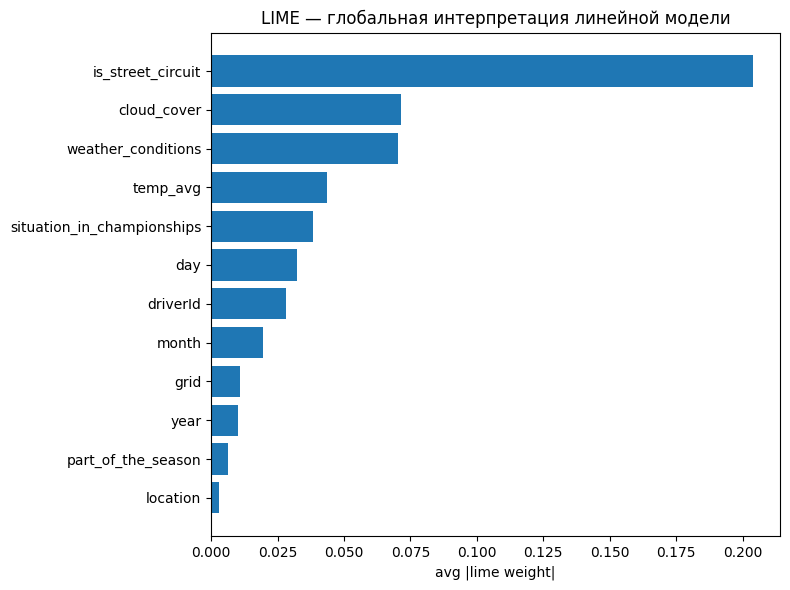

In [72]:
def plot_lime_importance(df, title, top_k=20):
    d = df.head(top_k)
    plt.figure(figsize=(8, 6))
    plt.barh(d['feature'][::-1], d['importance'][::-1])
    plt.title(title)
    plt.xlabel('avg |lime weight|')
    plt.tight_layout()
    plt.show()

plot_lime_importance(lime_lin_imp, 'LIME — глобальная интерпретация линейной модели')


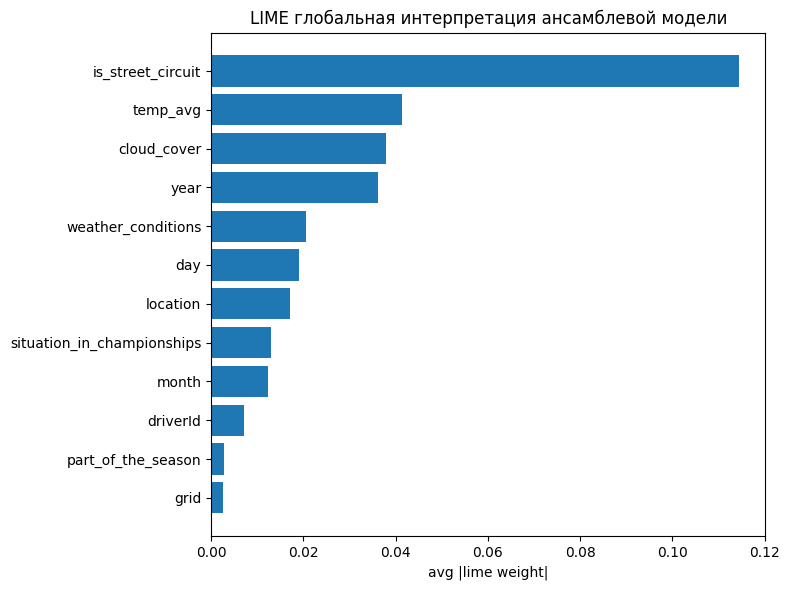

In [73]:
plot_lime_importance(lime_ens_imp, 'LIME глобальная интерпретация ансамблевой модели')

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


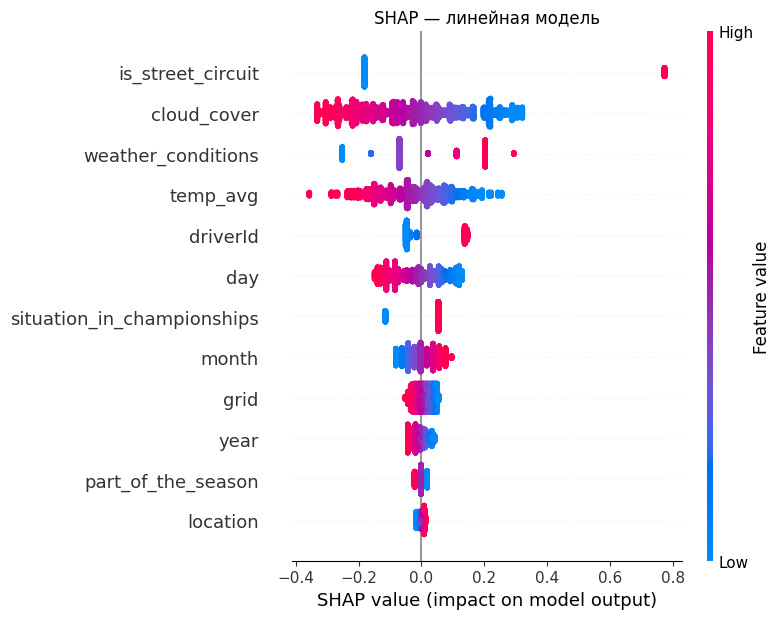

In [74]:
shap.initjs()

background_lin = shap.sample(X_train, 200, random_state=0)

lin_explainer = shap.LinearExplainer(
    lin_model,
    background_lin,
    feature_perturbation='interventional'
)

shap_values_lin = lin_explainer.shap_values(X_val)

shap.summary_plot(
    shap_values_lin,
    X_val,
    feature_names=feature_names,
    show=False
)
plt.title('SHAP — линейная модель')
plt.tight_layout()
plt.show()


Видим, что ключевые параметры различаются у линейной и ансамблевой моделей.

Видим, что линейная модель сильнее всего опирается на погодные условия, anomaly_safety_interaction, а еще сильно опирается на driverId... А ансамблевая модель уже интереснее - сильно опирается на is_street_circuit, race_instability_level, что правильно с точки зрения логики. Важно, что линейная модель почти не учитывает эти фичи при обучении.

## Финальное решение

А теперь catboost

In [75]:
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_val[cat_cols] = X_val[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [76]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=2e-4,
    depth=4,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_val, y_val), use_best_model=True)

0:	test: 0.5247966	best: 0.5247966 (0)	total: 65.7ms	remaining: 1m 5s
100:	test: 0.6055193	best: 0.6246928 (23)	total: 1.01s	remaining: 9.01s
200:	test: 0.5873963	best: 0.6246928 (23)	total: 2.57s	remaining: 10.2s
300:	test: 0.5764414	best: 0.6246928 (23)	total: 4.16s	remaining: 9.66s
400:	test: 0.5690497	best: 0.6246928 (23)	total: 5.5s	remaining: 8.22s
500:	test: 0.5651315	best: 0.6246928 (23)	total: 6.61s	remaining: 6.59s
600:	test: 0.5624423	best: 0.6246928 (23)	total: 7.39s	remaining: 4.91s
700:	test: 0.5598325	best: 0.6246928 (23)	total: 8.16s	remaining: 3.48s
800:	test: 0.5580053	best: 0.6246928 (23)	total: 9.66s	remaining: 2.4s
900:	test: 0.5552463	best: 0.6246928 (23)	total: 11.2s	remaining: 1.23s
999:	test: 0.5524577	best: 0.6246928 (23)	total: 12.7s	remaining: 0us

bestTest = 0.6246927874
bestIteration = 23

Shrink model to first 24 iterations.


In [77]:
threshold = 0.5004
y_proba = model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_proba >= threshold).astype(int)
acc = accuracy_score(y_test, y_pred_custom)
f1_s = f1_score(y_test, y_pred_custom)

print("ROC-AUC:", roc_auc)
print("Accuracy:", acc)
print("F1_Score:", f1_s)

ROC-AUC: 0.4958916083916084
Accuracy: 0.6604166666666667
F1_Score: 0.7073608617594255


In [78]:
result_df = pd.DataFrame({
    'raceId': test['raceId'],
    'y_true': test['safety_car_race'],
    'y_pred': y_pred_custom
})

In [79]:
result_df

,raceId,y_true,y_pred
11496,1145,1,1
11497,1145,1,1
11498,1145,1,1
11499,1145,1,1
11500,1145,1,1
...,...,...,...
11971,1168,0,0
11972,1168,0,0
11973,1168,0,0
11974,1168,0,0


In [80]:
print(y_pred_custom)
y_test

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,safety_car_race
11496,1
11497,1
11498,1
11499,1
11500,1
...,...
11971,0
11972,0
11973,0
11974,0
